In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 
from scipy import stats
%matplotlib inline

In [6]:
# 1. Daten Laden
df = pd.read_csv('allData.csv')

# Features auswählen
features = ['t_jup', 'i']
X_original = df[features].dropna()

/var/folders/tv/kwzyy9z51hl6kg2pqz9rjhz00000gn/T/ipykernel_8274/2500729643.py:2: DtypeWarning: Columns (17,23,24,25,36,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('allData.csv')


In [7]:
# 3. Skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# 4. Clustering auf den SKALIERTEN Daten
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10) # k=2 da wir Kometen vs Asteroiden trennen wollen
cluster_labels = kmeans.fit_predict(X_scaled)

X_original['cluster'] = cluster_labels

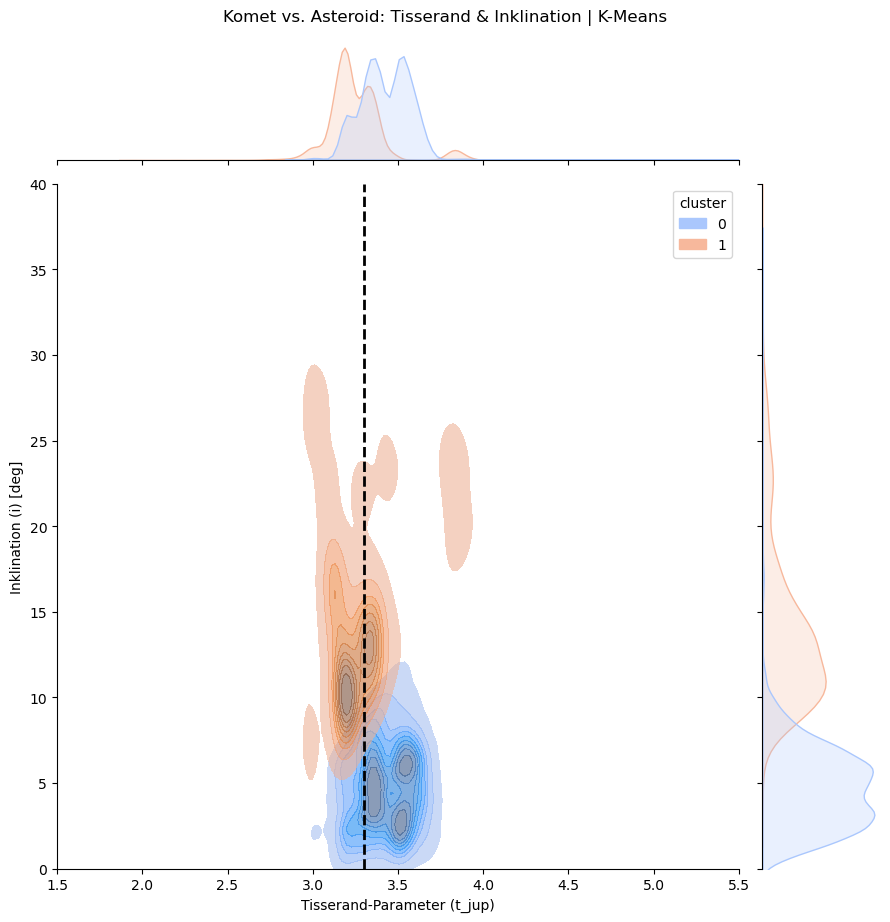

In [11]:
df_plot = X_original.sample(n=20000, random_state=42)

# 2. Der Plot
g = sns.jointplot(
    data=df_plot,
    x='t_jup', 
    y='i', 
    hue='cluster',     # Automatische Einfärbung nach Cluster
    kind='kde',        # 'kde' = Weiche Konturen
    palette='coolwarm', # Gute Farbwahl für Kontraste
    fill=True,         # Flächen füllen
    alpha=0.6,         # Transparenz, damit man Überlappungen sieht
    height=9,          # Größe des Bildes
    xlim=(1.5, 5.5),   # Fokus auf den Übergangsbereich
    ylim=(0, 40)       # Fokus auf Inklination
)

# 3. Achsenbeschriftungen und Titel
g.fig.suptitle('Komet vs. Asteroid: Tisserand & Inklination | K-Means', y=1.02)
g.set_axis_labels('Tisserand-Parameter (t_jup)', 'Inklination (i) [deg]')

# Die Kometen-Grenze einzeichnen (Senkrechte Linie bei 3.0)
g.ax_joint.axvline(x=3.3, color='black', linestyle='--', linewidth=2, label='Grenze T_J=3.0')

plt.show()

In [8]:
df.loc[X_original.index, 'cluster'] = X_original['cluster']
df.to_csv('clustered_kometVsAsteroid_kmeans.csv', index=False)

In [ ]:

from sklearn.cluster import DBSCAN

features = ['t_jup', 'i']

# Sicherstellen, dass die Daten sauber sind
if 'df' in locals():
    X_original = df[features].dropna()
else:
    # Fallback: Erneut laden, falls die Zelle oben nicht ausgeführt wurde
    try:
        df = pd.read_csv('allData.csv') # Oder der korrekte Pfad zu Ihrer Datei
        X_original = df[features].dropna()
    except:
        print("Bitte führen Sie zuerst die Zelle zum Laden der Daten aus.")


# 50.000 Punkte wegen Performance
if len(X_original) > 200000:
    X_sample = X_original.sample(n=200000, random_state=42).copy()
else:
    X_sample = X_original.copy()

 
# Ohne Skalierung würde die Inklination das Clustering dominieren.
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

# eps=0.3: Radius der Nachbarschaft (in Standardabweichungen)
# min_samples=10: Mindestanzahl Objekte pro Cluster
# n_jobs=-1: Nutzt alle CPU-Kerne für Geschwindigkeit
dbscan = DBSCAN(eps=0.3, min_samples=10, n_jobs=-1)
labels = dbscan.fit_predict(X_sample_scaled)

# Ergebnisse speichern
X_sample['cluster'] = labels

# Analyse der Cluster-Inhalte
for label in sorted(X_sample['cluster'].unique()):
    subset = X_sample[X_sample['cluster'] == label]
    
    # Name der Gruppe
    group_name = f"Cluster {label}" if label != -1 else "Noise (Rauschen)"
    
    # Durchschnittlicher Tisserand-Parameter
    avg_tj = subset['t_jup'].mean()
    count = len(subset)
    



n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

Datensatz ist groß (875653). Ziehe Sample von 200.000 Punkten...
Starte DBSCAN Clustering...
Noise (Rauschen): 736 Objekte | Ø T_Jup = 4.62
   -> Verdacht auf Asteroiden
Cluster 0: 199164 Objekte | Ø T_Jup = 3.35
   -> Verdacht auf Asteroiden
Cluster 1: 22 Objekte | Ø T_Jup = 4.26
   -> Verdacht auf Asteroiden
Cluster 2: 58 Objekte | Ø T_Jup = 5.93
   -> Verdacht auf Asteroiden
Cluster 3: 10 Objekte | Ø T_Jup = 4.23
   -> Verdacht auf Asteroiden
Cluster 4: 10 Objekte | Ø T_Jup = 5.77
   -> Verdacht auf Asteroiden


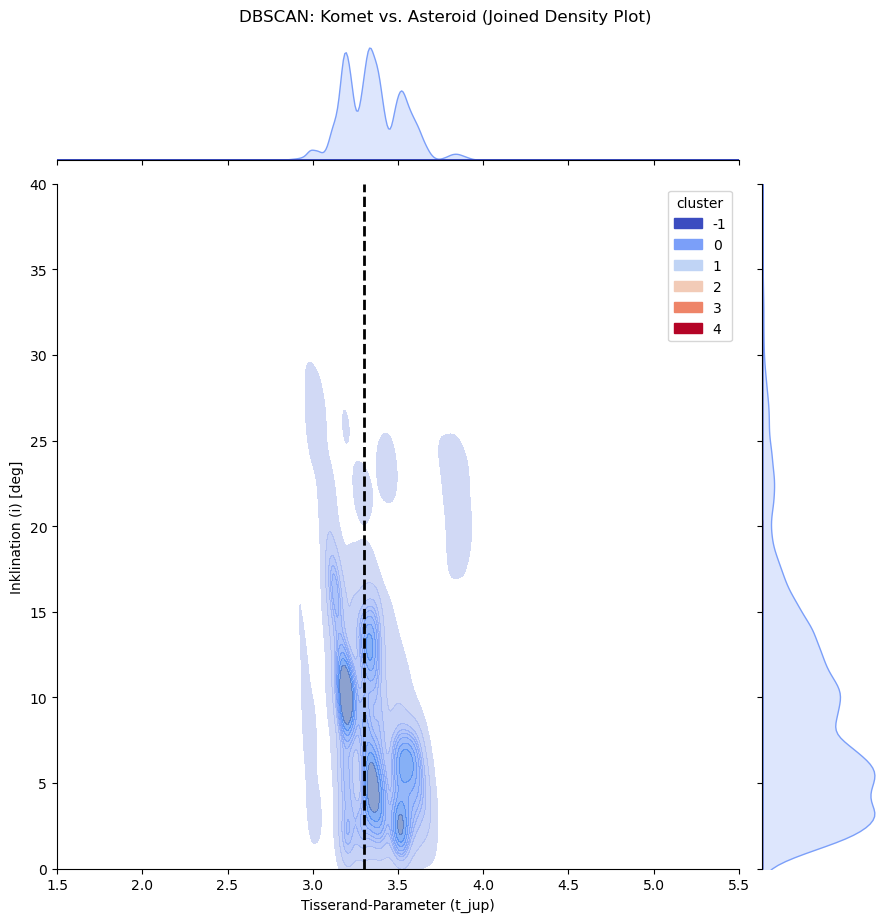

In [ ]:

# 1. Sampling für Performance (KDE Plots sind sehr rechenintensiv)
# Wir nehmen max. 20.000 Punkte aus dem DBSCAN-Ergebnis (X_sample)
if len(X_sample) > 200000:
    df_dbscan_plot = X_sample.sample(n=200000, random_state=42)
else:
    df_dbscan_plot = X_sample

# 2. Der Plot
g = sns.jointplot(
    data=df_dbscan_plot,
    x='t_jup', 
    y='i', 
    hue='cluster',      # Färbt nach den DBSCAN-Clustern (-1 ist Rauschen)
    kind='kde',         # 'kde' für die Dichte-Darstellung (wie bei K-Means)
    palette='coolwarm',  # 'viridis' oder 'coolwarm' für gute Unterscheidung
    fill=True,          # Flächen füllen
    alpha=0.6,          # Transparenz
    height=9,
    xlim=(1.5, 5.5),   
    ylim=(0, 40)
)

# 3. Titel und Hilfslinien
g.fig.suptitle('DBSCAN: Komet vs. Asteroid (Joined Density Plot)', y=1.02)
g.set_axis_labels('Tisserand-Parameter (t_jup)', 'Inklination (i) [deg]')

g.ax_joint.axvline(x=3.3, color='black', linestyle='--', linewidth=2, label='Grenze T_J=3.3')

plt.show()

In [6]:
# Filtere das Rauschen heraus
noise = X_sample[X_sample['cluster'] == -1]

# Suche nach echten Kometen im Rauschen
comets_in_noise = noise[noise['t_jup'] < 3.0]

print(f"Anzahl Objekte im Rauschen: {len(noise)}")
print(f"Davon Kometen-Kandidaten (T_J < 3): {len(comets_in_noise)}")

Anzahl Objekte im Rauschen: 736
Davon Kometen-Kandidaten (T_J < 3): 103


In [ ]:
df.loc[X_sample.index, 'cluster'] = X_sample['cluster']
df.to_csv('clustered_kometVsAsteroid_kmeans.csv', index=False)

print(f"\n✅ Export erfolgreich! Datei gespeichert")